In [ ]:
#Librerias
import pandas as pd
import os
import kagglehub
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

In [ ]:
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dcastro88","key":"f6a3eed632e767f714359687435f57b1"}'}

In [ ]:
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -l ~/.kaggle/
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 65 Jun 23 13:37 kaggle.json
{"username":"dcastro88","key":"f6a3eed632e767f714359687435f57b1"}

In [ ]:
!kaggle datasets download -d arafatsahinafridi/multi-class-driver-behavior-image-dataset

Dataset URL: https://www.kaggle.com/datasets/arafatsahinafridi/multi-class-driver-behavior-image-dataset
License(s): unknown
 99% 2.36G/2.38G [00:34<00:00, 215MB/s]
100% 2.38G/2.38G [00:34<00:00, 73.5MB/s]


In [ ]:
!unzip -q multi-class-driver-behavior-image-dataset.zip -d driver_dataset

In [ ]:
import os

base_dir = 'driver_dataset/Multi-Class Driver Behavior Image Dataset'

for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_folder}: {num_images} imágenes")

texting_phone: 1561 imágenes
turning: 1339 imágenes
safe_driving: 1679 imágenes
talking_phone: 1513 imágenes
other_activities: 1184 imágenes


El dataset inicial no presenta un desbalanceo de clases tan significativo.

## Previasualización de las imágenes

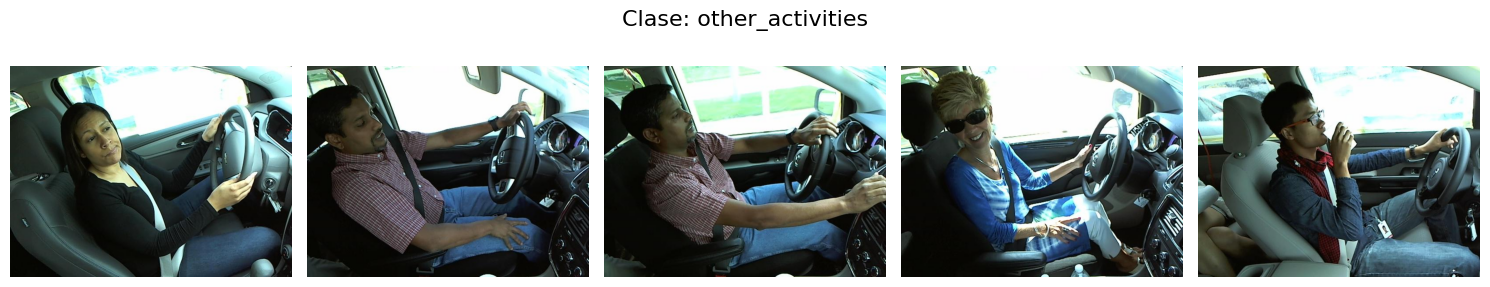

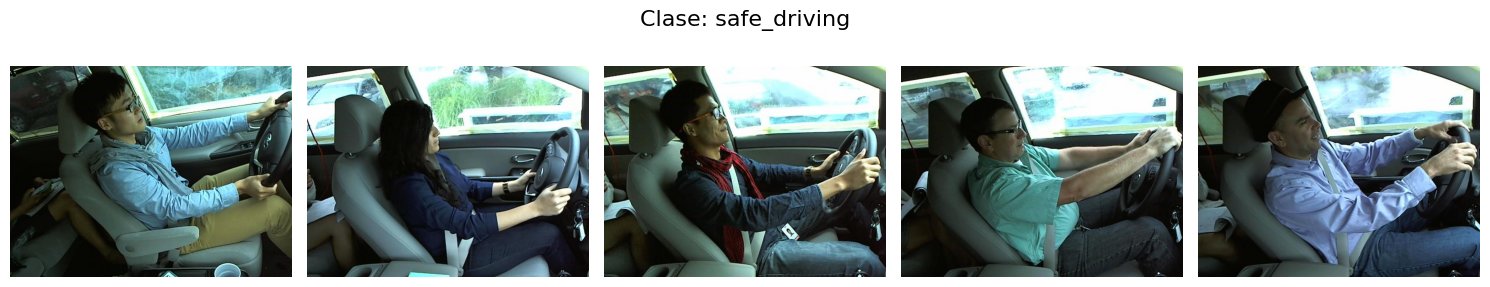

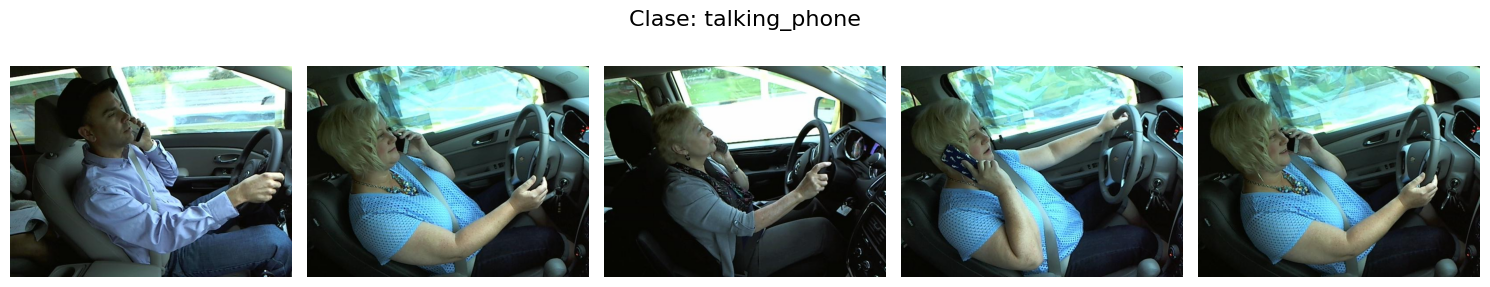

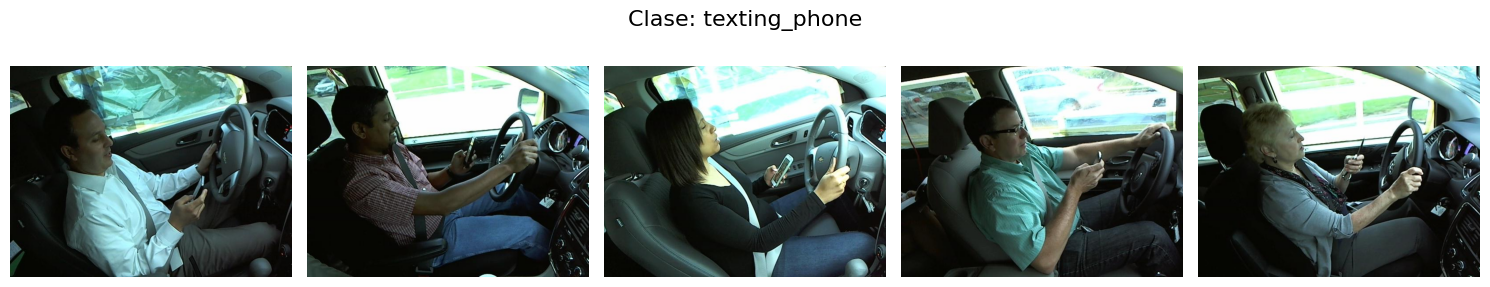

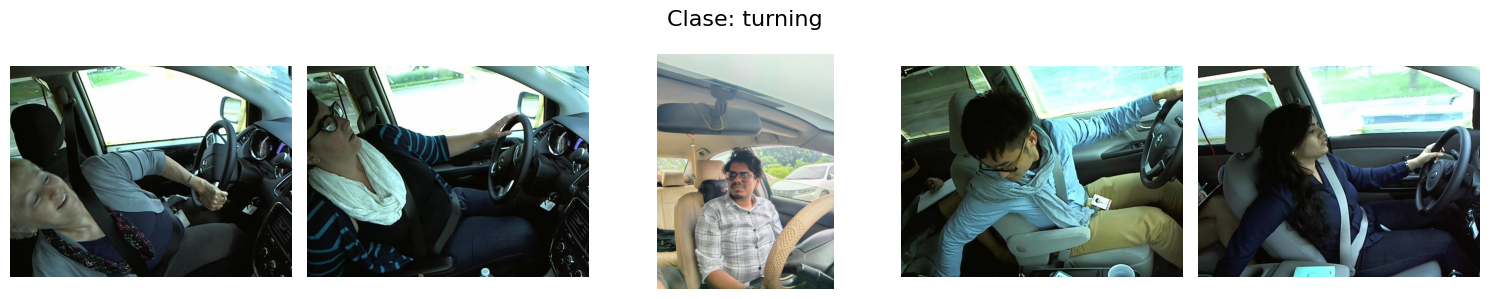

In [ ]:
class_names = os.listdir(base_dir)

for class_name in sorted(class_names):
    class_path = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_path)

    sample_images = random.sample(image_files, 5)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Clase: {class_name}', fontsize=16)

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(class_path, img_file)
        image = Image.open(img_path)

        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
img_size = (64, 64)
batch_size = 32

In [ ]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 7276 files belonging to 5 classes.
Using 5821 files for training.
Found 7276 files belonging to 5 classes.
Using 1455 files for validation.


In [ ]:
class_names = train_ds_raw.class_names
print("Clases:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

Clases: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']


## Modelo 1 Sencillo.

In [ ]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),  # Normalización
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # 5 clases
])

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,845 (2.61 MB)

 Trainable params: 683,845 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 20

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 96s 300ms/step - accuracy: 0.2964 - loss: 1.5091 - val_accuracy: 0.6756 - val_loss: 0.9303
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step - accuracy: 0.6742 - loss: 0.8605 - val_accuracy: 0.8419 - val_loss: 0.4785
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 42s 229ms/step - accuracy: 0.8072 - loss: 0.5092 - val_accuracy: 0.8687 - val_loss: 0.3748
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.8631 - loss: 0.3681 - val_accuracy: 0.8873 - val_loss: 0.2849
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 38s 207ms/step - accuracy: 0.8848 - loss: 0.2940 - val_accuracy: 0.9038 - val_loss: 0.2756
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.9135 - loss: 0.2304 - val_accuracy: 0.9175 - val_loss: 0.2245
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.9137 - loss: 0.2203 - val_accuracy: 0.9223 - val_loss: 0.2228
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.9404 - loss: 0

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

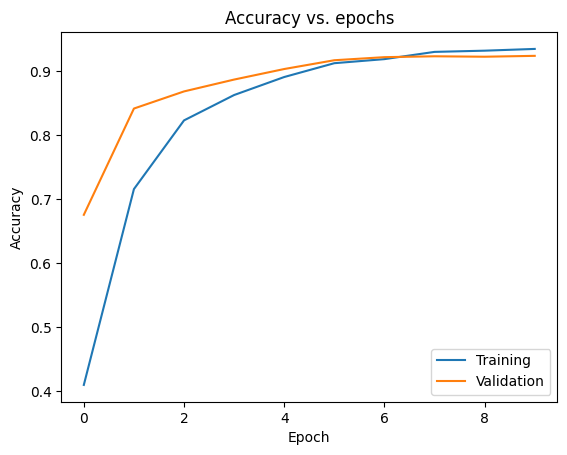

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

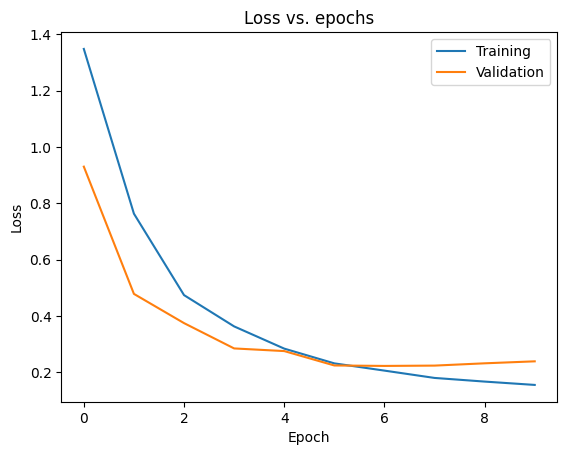

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### **Métricas en entrenamiento**

In [ ]:
y_train_true = []
y_train_pred = []

for images, labels in train_ds_raw:  # <-- dataset original sin prefetch
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_train_true.extend(labels.numpy())
    y_train_pred.extend(pred_labels)

y_train_true = np.array(y_train_true)
y_train_pred = np.array(y_train_pred)

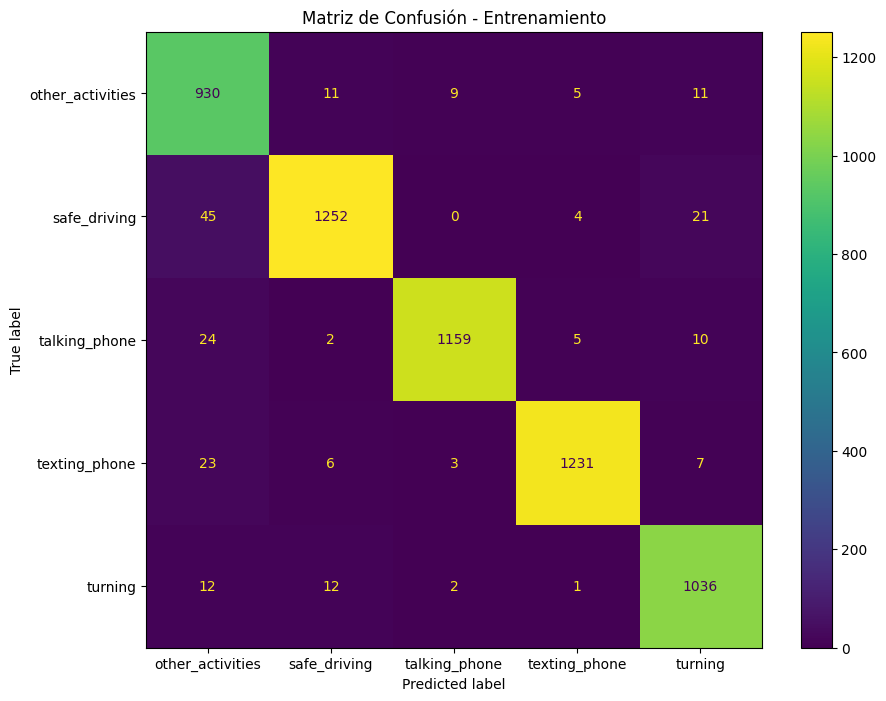

Reporte de clasificación - Entrenamiento:

                  precision    recall  f1-score   support

other_activities       0.90      0.96      0.93       966
    safe_driving       0.98      0.95      0.96      1322
   talking_phone       0.99      0.97      0.98      1200
   texting_phone       0.99      0.97      0.98      1270
         turning       0.95      0.97      0.96      1063

        accuracy                           0.96      5821
       macro avg       0.96      0.96      0.96      5821
    weighted avg       0.96      0.96      0.96      5821



In [ ]:
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp_train.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión - Entrenamiento')
plt.show()
print("Reporte de clasificación - Entrenamiento:\n")
print(classification_report(y_train_true, y_train_pred, target_names=class_names))

## **Métricas en validación**

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds_raw:
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

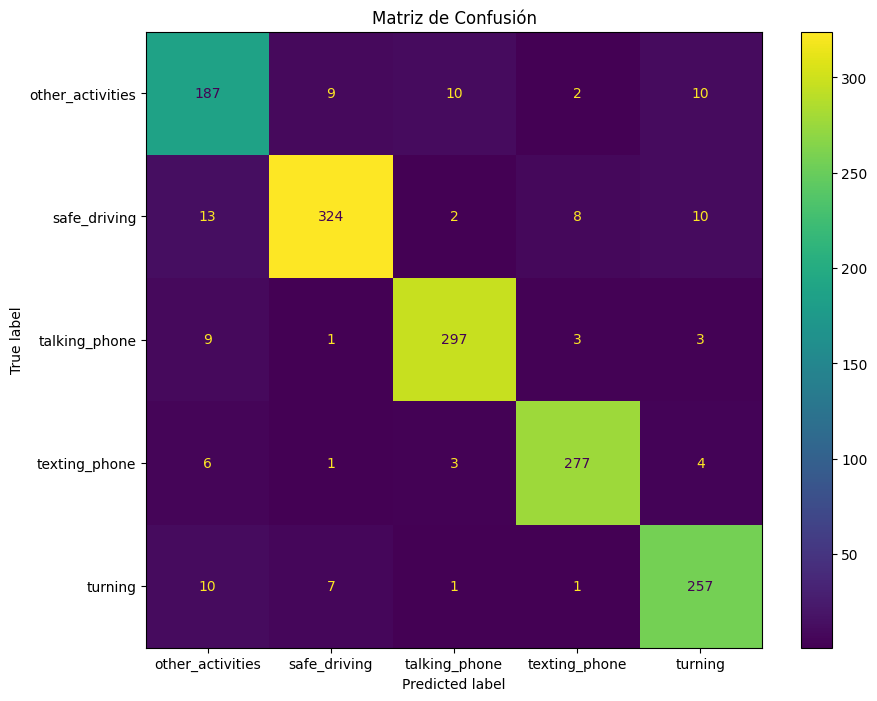

Reporte de clasificación:

                  precision    recall  f1-score   support

other_activities       0.83      0.86      0.84       218
    safe_driving       0.95      0.91      0.93       357
   talking_phone       0.95      0.95      0.95       313
   texting_phone       0.95      0.95      0.95       291
         turning       0.90      0.93      0.92       276

        accuracy                           0.92      1455
       macro avg       0.92      0.92      0.92      1455
    weighted avg       0.92      0.92      0.92      1455



In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

## Modelo 2. Arquitectura más compleja.


In [ ]:
model_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 305,957 (1.17 MB)

 Trainable params: 305,061 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history_model2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.2566 - loss: 1.6756 - val_accuracy: 0.1491 - val_loss: 1.9853
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 193s 990ms/step - accuracy: 0.4671 - loss: 1.2739 - val_accuracy: 0.3292 - val_loss: 2.2563
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 177s 971ms/step - accuracy: 0.6932 - loss: 0.7958 - val_accuracy: 0.4653 - val_loss: 1.3483
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 179s 984ms/step - accuracy: 0.8086 - loss: 0.5188 - val_accuracy: 0.7649 - val_loss: 0.6318
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8580 - loss: 0.3857 - val_accuracy: 0.3526 - val_loss: 2.5096
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 182s 998ms/step - accuracy: 0.8894 - loss: 0.3126 - val_accuracy: 0.7155 - val_loss: 0.8775
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 180s 990ms/step - accuracy: 0.8985 - loss: 0.2770 - val_accuracy: 0.7883 - val_loss: 0.6137
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9120 - loss: 0.

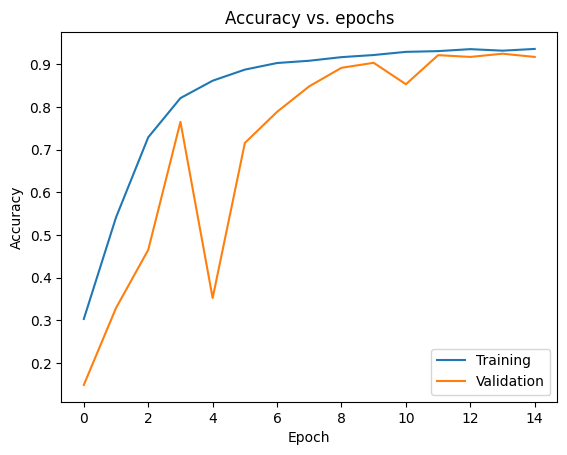

In [ ]:
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

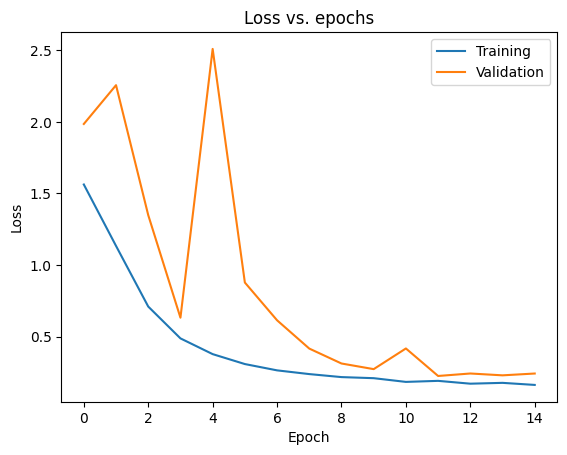

In [ ]:
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_train_true_2 = []
y_train_pred_2 = []

for images, labels in train_ds_raw:  # <-- dataset original sin prefetch
    preds = model_2.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_train_true_2.extend(labels.numpy())
    y_train_pred_2.extend(pred_labels)

y_train_true_2 = np.array(y_train_true_2)
y_train_pred_2 = np.array(y_train_pred_2)

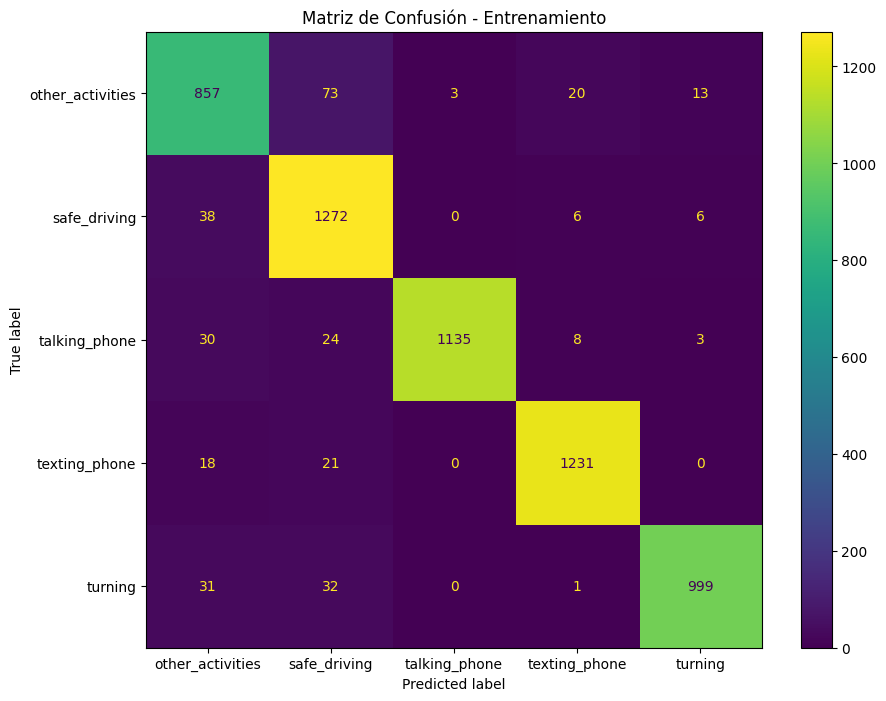

Reporte de clasificación - Entrenamiento:

                  precision    recall  f1-score   support

other_activities       0.88      0.89      0.88       966
    safe_driving       0.89      0.96      0.93      1322
   talking_phone       1.00      0.95      0.97      1200
   texting_phone       0.97      0.97      0.97      1270
         turning       0.98      0.94      0.96      1063

        accuracy                           0.94      5821
       macro avg       0.94      0.94      0.94      5821
    weighted avg       0.95      0.94      0.94      5821



In [ ]:
cm_train = confusion_matrix(y_train_true_2, y_train_pred_2)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp_train.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión - Entrenamiento')
plt.show()
print("Reporte de clasificación - Entrenamiento:\n")
print(classification_report(y_train_true_2, y_train_pred_2, target_names=class_names))

In [ ]:
y_true_2 = []
y_pred_2 = []

for images, labels in val_ds_raw:
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_true_2.extend(labels.numpy())
    y_pred_2.extend(pred_labels)
y_true_2 = np.array(y_true_2)
y_pred_2 = np.array(y_pred_2)

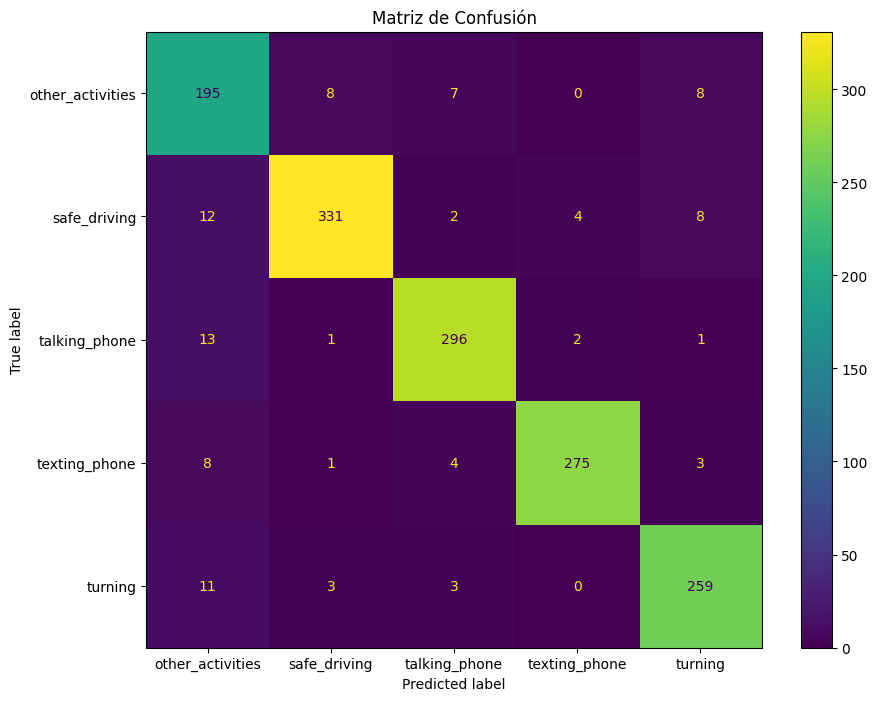

Reporte de clasificación:

                  precision    recall  f1-score   support

other_activities       0.82      0.89      0.85       218
    safe_driving       0.96      0.93      0.94       357
   talking_phone       0.95      0.95      0.95       313
   texting_phone       0.98      0.95      0.96       291
         turning       0.93      0.94      0.93       276

        accuracy                           0.93      1455
       macro avg       0.93      0.93      0.93      1455
    weighted avg       0.93      0.93      0.93      1455



In [ ]:
cm = confusion_matrix(y_true_2, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

print("Reporte de clasificación:\n")
print(classification_report(y_true_2, y_pred_2, target_names=class_names))

## Modelo 3. Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
img_size = (128, 128)
batch_size = 32

In [ ]:
train_ds_128 = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds_128 = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds_128.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds_128 = train_ds_128.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_128 = val_ds_128.cache().prefetch(buffer_size=AUTOTUNE)

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

Found 7276 files belonging to 5 classes.
Using 5821 files for training.
Found 7276 files belonging to 5 classes.
Using 1455 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model_transfer = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model_transfer.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
model_transfer.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,825 (10.50 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,228 (1.26 MB)

In [ ]:
history_transfer = model_transfer.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 161s 810ms/step - accuracy: 0.4159 - loss: 1.5635 - val_accuracy: 0.7354 - val_loss: 0.8001
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 130s 418ms/step - accuracy: 0.6914 - loss: 0.8138 - val_accuracy: 0.8158 - val_loss: 0.5827
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 76s 420ms/step - accuracy: 0.7776 - loss: 0.5991 - val_accuracy: 0.8467 - val_loss: 0.4535
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 76s 417ms/step - accuracy: 0.8153 - loss: 0.5028 - val_accuracy: 0.8639 - val_loss: 0.3896
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 76s 416ms/step - accuracy: 0.8427 - loss: 0.4262 - val_accuracy: 0.8564 - val_loss: 0.4025
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 83s 455ms/step - accuracy: 0.8575 - loss: 0.3853 - val_accuracy: 0.8832 - val_loss: 0.3484
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 83s 456ms/step - accuracy: 0.8615 - loss: 0.3546 - val_accuracy: 0.8804 - val_loss: 0.3458
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 77s 425ms/step - accuracy: 0.8841 - loss:

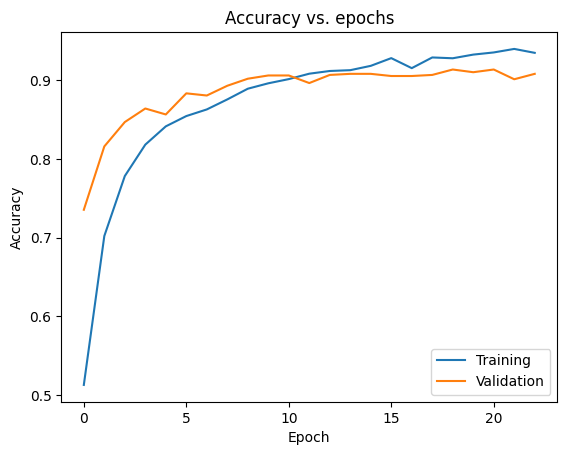

In [ ]:
plt.plot(history_transfer.history['accuracy'])
plt.plot(history_transfer.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

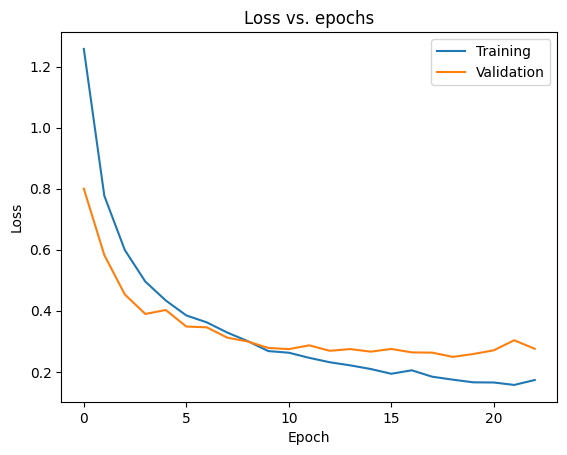

In [ ]:
plt.plot(history_transfer.history['loss'])
plt.plot(history_transfer.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_train_true_3 = []
y_train_pred_3 = []

for images, labels in train_ds_128:  # <-- dataset original sin prefetch
    preds = model_transfer.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_train_true_3.extend(labels.numpy())
    y_train_pred_3.extend(pred_labels)

y_train_true_3 = np.array(y_train_true_3)
y_train_pred_3 = np.array(y_train_pred_3)

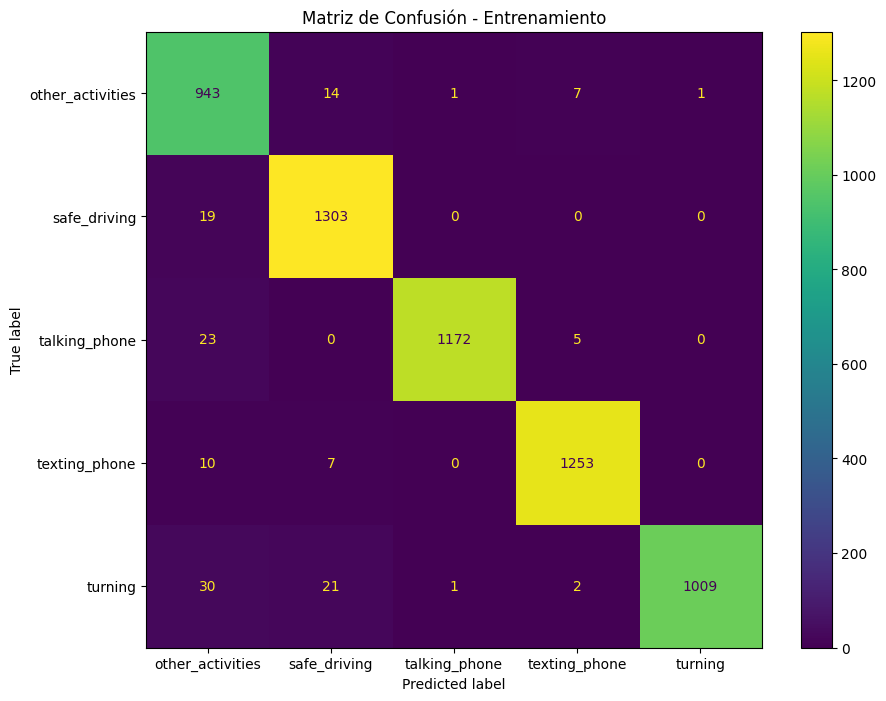

Reporte de clasificación - Entrenamiento:

                  precision    recall  f1-score   support

other_activities       0.92      0.98      0.95       966
    safe_driving       0.97      0.99      0.98      1322
   talking_phone       1.00      0.98      0.99      1200
   texting_phone       0.99      0.99      0.99      1270
         turning       1.00      0.95      0.97      1063

        accuracy                           0.98      5821
       macro avg       0.98      0.97      0.97      5821
    weighted avg       0.98      0.98      0.98      5821



In [ ]:
cm_train = confusion_matrix(y_train_true_3, y_train_pred_3)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp_train.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión - Entrenamiento')
plt.show()
print("Reporte de clasificación - Entrenamiento:\n")
print(classification_report(y_train_true_3, y_train_pred_3, target_names=class_names))

In [ ]:
y_true_3 = []
y_pred_3 = []

for images, labels in val_ds_128:
    preds = model_transfer.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_true_3.extend(labels.numpy())
    y_pred_3.extend(pred_labels)
y_true_3 = np.array(y_true_3)
y_pred_3 = np.array(y_pred_3)

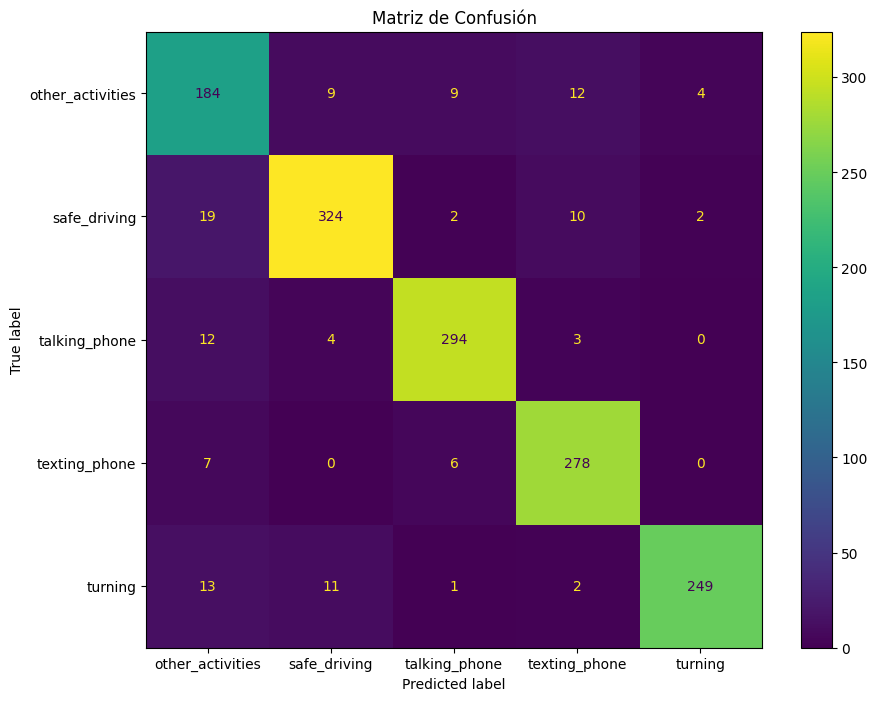

Reporte de clasificación:

                  precision    recall  f1-score   support

other_activities       0.78      0.84      0.81       218
    safe_driving       0.93      0.91      0.92       357
   talking_phone       0.94      0.94      0.94       313
   texting_phone       0.91      0.96      0.93       291
         turning       0.98      0.90      0.94       276

        accuracy                           0.91      1455
       macro avg       0.91      0.91      0.91      1455
    weighted avg       0.92      0.91      0.91      1455



In [ ]:
cm = confusion_matrix(y_true_3, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

print("Reporte de clasificación:\n")
print(classification_report(y_true_3, y_pred_3, target_names=class_names))

## Reentrenamos el modelo y lo guardamos

El modelo elegido fue el modelo 1, ya que obtuvo las mejores métricas y en términos computacionales es el más eficiente. Ahora pasamos a reentrenar la misma arquitectura pero con todo los datos disponibles, y a guardar el modelo para el uso en la aplicación.

In [ ]:
model_to_deploy = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),  # Normalización

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')  # 5 clases
])

In [ ]:
full_ds = image_dataset_from_directory(
    base_dir,
    image_size=(64, 64),
    batch_size=32
)

Found 7276 files belonging to 5 classes.


In [ ]:
full_ds = full_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model_to_deploy.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_final_model = model_to_deploy.fit(full_ds, epochs=20)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 93s 400ms/step - accuracy: 0.3119 - loss: 1.5115
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.7279 - loss: 0.7537
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - accuracy: 0.8282 - loss: 0.4680
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.8740 - loss: 0.3426
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9014 - loss: 0.2575
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.9069 - loss: 0.2347
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 72s 194ms/step - accuracy: 0.9257 - loss: 0.2057
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 46s 203ms/step - accuracy: 0.9356 - loss: 0.1645
Epoch 9/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9409 - loss: 0.1506
Epoch 10/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 190ms/step - accuracy: 0.9461 - loss: 0.1391
Epoch 11/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.9432 - loss: 0.1300
Epoch 12/20
228/228

In [ ]:
#Guardamos el modelo
model_to_deploy.save('modelo_final_cnn.h5')

In [ ]:
model_to_deploy.save('modelo_final.keras')

validaciones

Reporte de clasificación:

                  precision    recall  f1-score   support

other_activities       0.97      1.00      0.99      1184
    safe_driving       0.99      0.99      0.99      1679
   talking_phone       1.00      0.99      0.99      1513
   texting_phone       1.00      0.99      1.00      1561
         turning       1.00      0.98      0.99      1339

        accuracy                           0.99      7276
       macro avg       0.99      0.99      0.99      7276
    weighted avg       0.99      0.99      0.99      7276



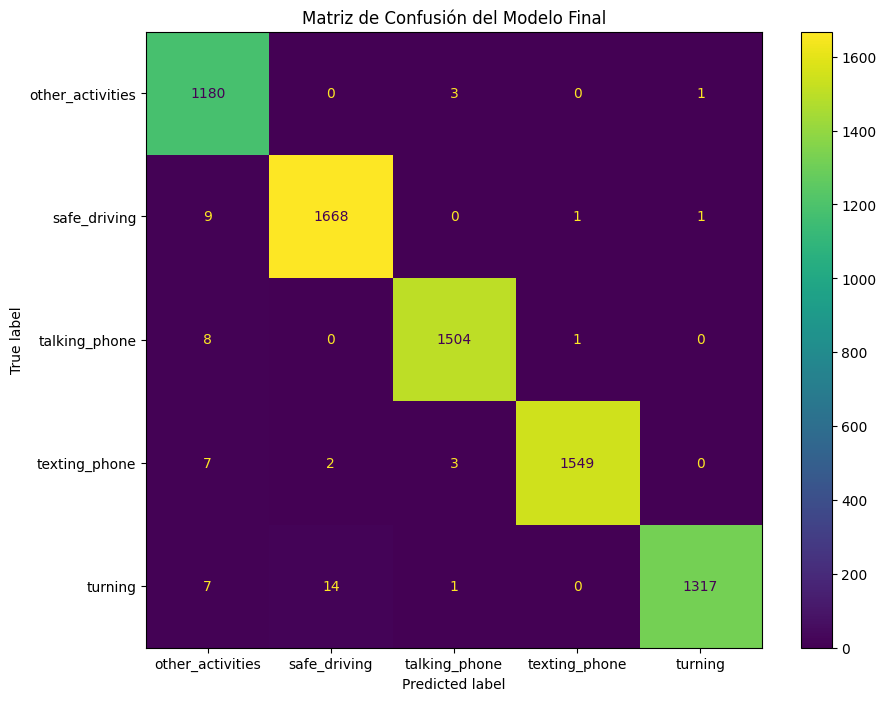

In [ ]:
y_true = []
y_pred = []

for images_batch, labels_batch in full_ds:
    preds = model_to_deploy.predict(images_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

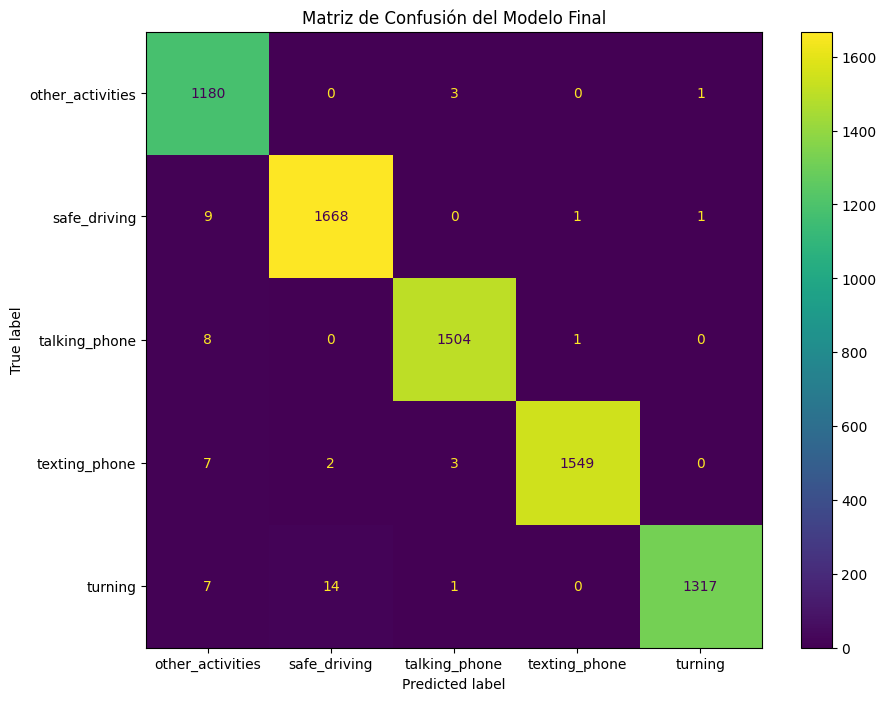

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', values_format='d')
plt.title("Matriz de Confusión del Modelo Final")
plt.show()

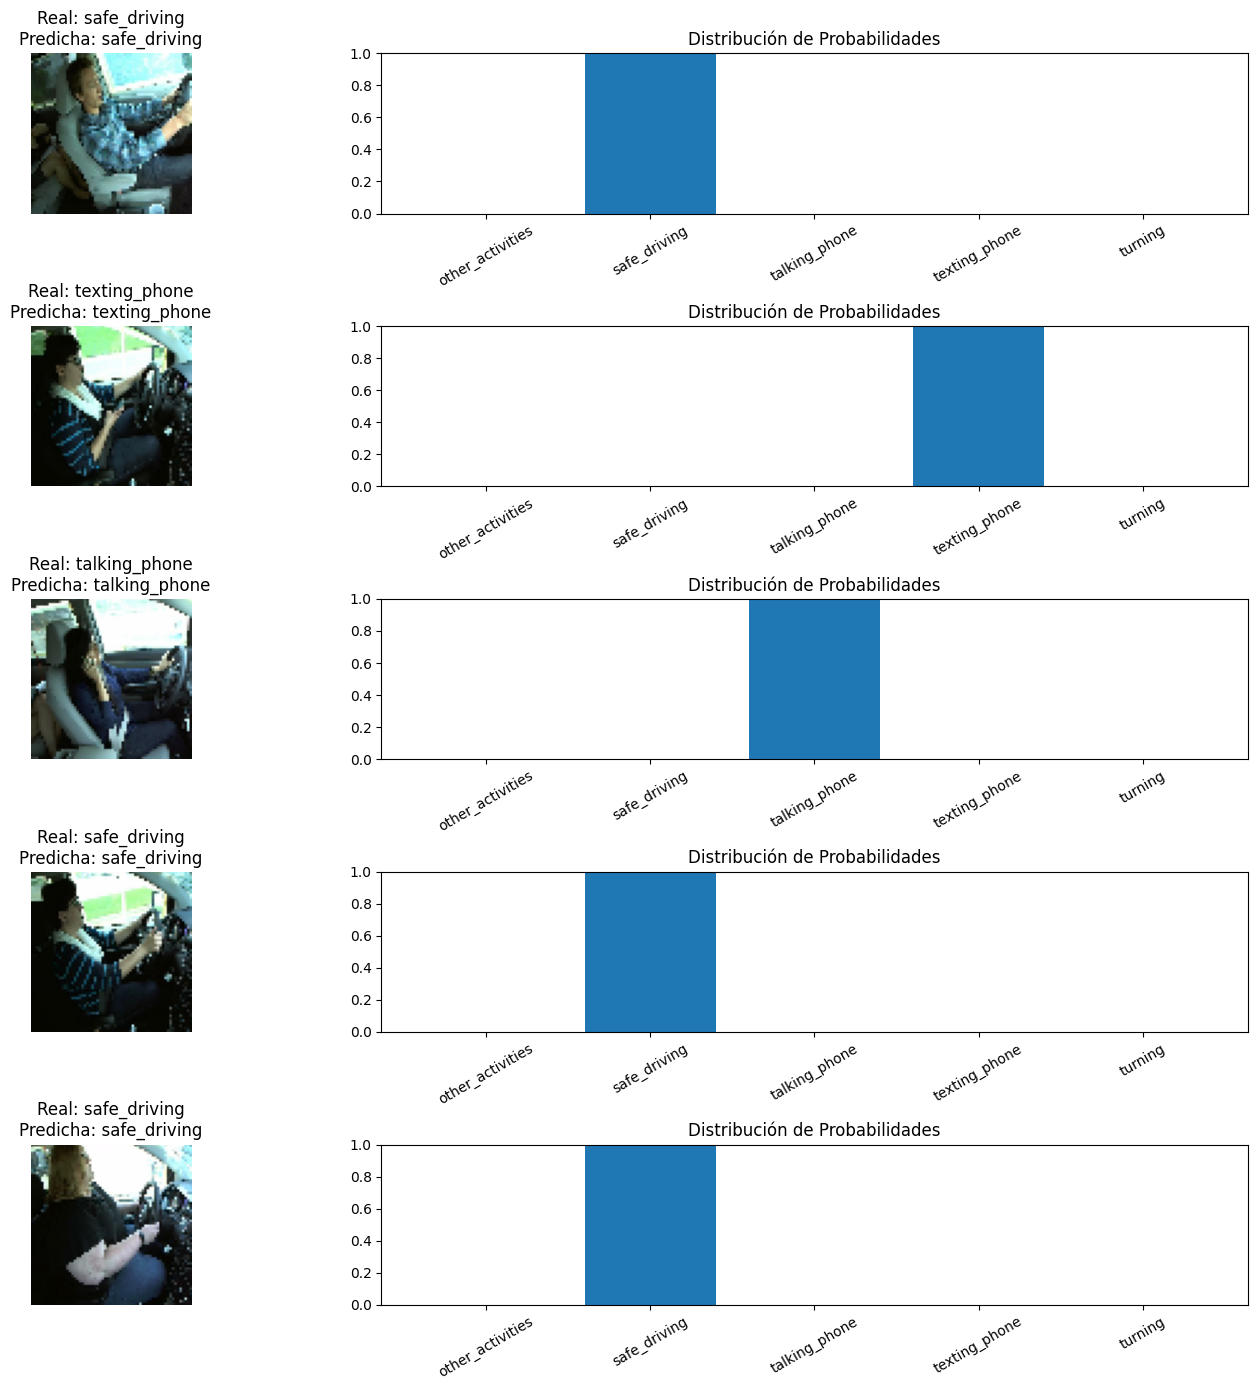

In [ ]:
images = []
labels = []

for img_batch, label_batch in full_ds.take(1):
    images.extend(img_batch.numpy())
    labels.extend(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

random_indices = np.random.choice(len(images), 5, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]

predictions = model_to_deploy.predict(sample_images, verbose=0)

fig, axes = plt.subplots(5, 2, figsize=(16, 14))
fig.subplots_adjust(hspace=0.6)

for i, (image, label, prediction) in enumerate(zip(sample_images, sample_labels, predictions)):
    pred_class = np.argmax(prediction)
    true_class = label
    axes[i, 0].imshow(image.astype("uint8"))
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Real: {class_names[true_class]}\nPredicha: {class_names[pred_class]}", fontsize=12)
    axes[i, 1].bar(range(len(class_names)), prediction, tick_label=class_names)
    axes[i, 1].set_ylim([0, 1])
    axes[i, 1].set_title("Distribución de Probabilidades", fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
import glob
from PIL import Image
import random

image_paths = []
image_labels = []

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    paths = sorted(glob.glob(os.path.join(class_dir, "*.jpg")))
    image_paths.extend(paths)
    image_labels.extend([idx] * len(paths))

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (64, 64))
    img = img / 255.0
    return img

wrong_paths = []
wrong_true = []
wrong_pred = []
wrong_probs = []

for path, true_label in zip(image_paths, image_labels):
    img_tensor = tf.expand_dims(preprocess_image(path), 0)
    pred = model_to_deploy.predict(img_tensor, verbose=0)[0]
    pred_label = np.argmax(pred)
    if pred_label != true_label:
        wrong_paths.append(path)
        wrong_true.append(true_label)
        wrong_pred.append(pred_label)
        wrong_probs.append(pred)

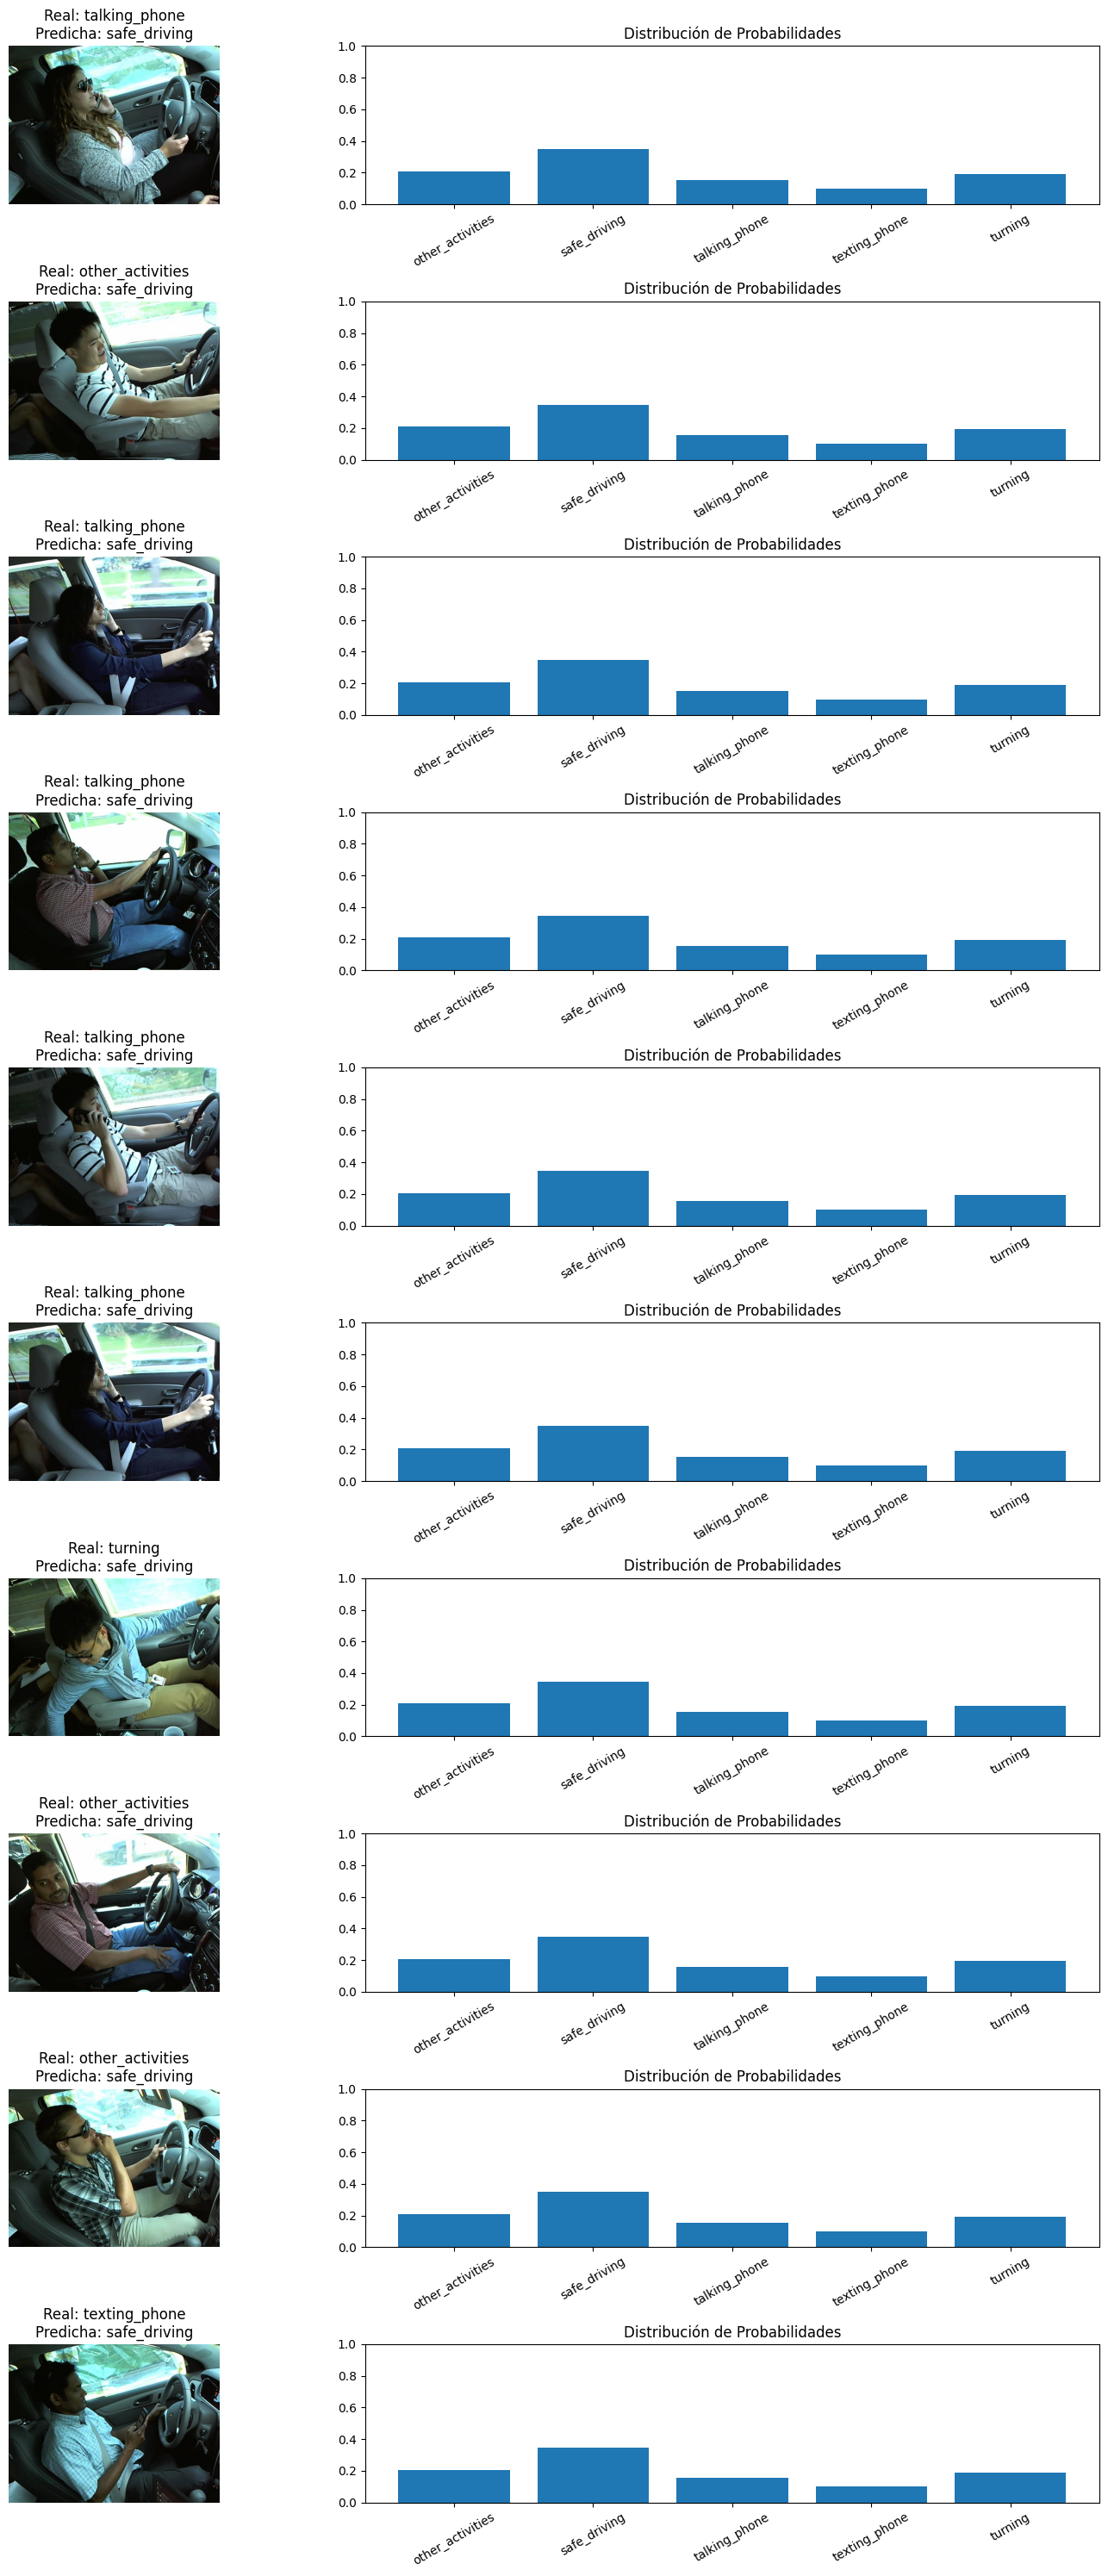

In [ ]:
sample_size = min(10, len(wrong_paths))
sample_indices = random.sample(range(len(wrong_paths)), sample_size)

fig, axes = plt.subplots(sample_size, 2, figsize=(16, 3 * sample_size))
fig.subplots_adjust(hspace=0.6)

for i, idx in enumerate(sample_indices):
    image = Image.open(wrong_paths[idx])
    true_class = wrong_true[idx]
    pred_class = wrong_pred[idx]
    prediction = wrong_probs[idx]

    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Real: {class_names[true_class]}\nPredicha: {class_names[pred_class]}", fontsize=12)

    axes[i, 1].bar(range(len(class_names)), prediction, tick_label=class_names)
    axes[i, 1].set_ylim([0, 1])
    axes[i, 1].set_title("Distribución de Probabilidades", fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()